# TME 9: Explication des Données: Clustering

- LE LORIER Yann
- NGUYEN Hoang-Son

In [23]:
from sklearn.datasets import make_moons, make_blobs
import matplotlib.pyplot as plt
import numpy as np

### Fonction pour tracer les lignes de niveaux

In [24]:
def plot_contour(X, f_appart, c, delta=0.2):
    """
    X: np.array, taille = n*2
    """
    xs = np.arange(np.min(X[:,0]), np.max(X[:,0]), delta)
    ys = np.arange(np.min(X[:,1]), np.max(X[:,1]), delta)
    x, y = np.meshgrid(xs, ys)
    xys = np.stack((x,y), axis=0).reshape((2,-1)).transpose()

    W, D, U = f_appart(c, xys)
    ## return max of the two Us
    plt.contourf(xs, ys, U[:,0].reshape((len(ys), len(xs))))

    plt.show()

## C-Moyennes floues

In [25]:
m = 2
c = 2
n = 1000

In [26]:
# choisir c centres aléatoirement
def init_W(X, c, d):
    W = np.zeros(shape=(c, d), dtype=float)
    min_axes = np.min(X.T, axis=1)
    max_axes = np.max(X.T, axis=1)

    for i in range(c):
        for j in range(d):
            W[i][j] = np.random.uniform(low=min_axes[j], high=max_axes[j])
    return W

def update_D(D, X, W):
    for i in range(len(X)):
        for r in range(len(W)):
            D[i, r] = np.linalg.norm(X[i]-W[r])
    return D

def update_U(D, U, m):
    for i in range(len(U)):
        for r in range(len(U[0])):
            somme = 0.
            for s in range(len(U[0])):
                somme += (D[i, r]/D[i, s])**(2/(m-1))
            U[i, r] = 1/somme
    return U

def update_W(W, U, X, m):
    W_new = np.zeros_like(W)
    for r in range(len(W)):
        W_new[r] = ((U[:, r]**m)[:,None]*X).sum(0)/(U[:, r]**m).sum()
    return W_new

def is_converged(W_old, W_new, thresh=1e-7):
    if np.linalg.norm(W_old-W_new, axis=-1).sum() < thresh:
        return True
    return False

In [27]:
import copy

def c_means(c, X, m=2):
    n = len(X)
    d = len(X[0])
    # distances
    D = np.zeros(shape=(n, c))
    # degres d'appartenance
    U = np.zeros(shape=(n, c))

    W = init_W(X, c, d)
    converged = False
    while not converged:
        D = update_D(D, X, W)
        U = update_U(D, U, m)
        W_new = update_W(W, U, X, m)
        
        if is_converged(W_old=W, W_new=W_new):
            converged = True
        W = W_new
    return W, D, U

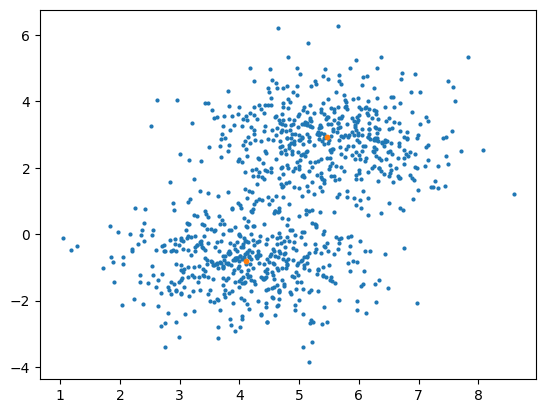

In [28]:
n = 1000
X, Y = make_blobs(n, centers=2, cluster_std=1.)
W, D, U = c_means(c = 2, X=X, m = 2)
plt.scatter(X[...,0], X[..., 1], s=4)
plt.scatter(W[:, 0], W[:, 1], s=10)
plt.show()

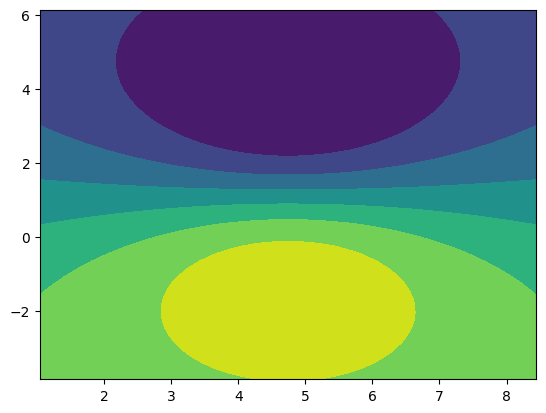

In [29]:
plot_contour(X, c_means, 2)

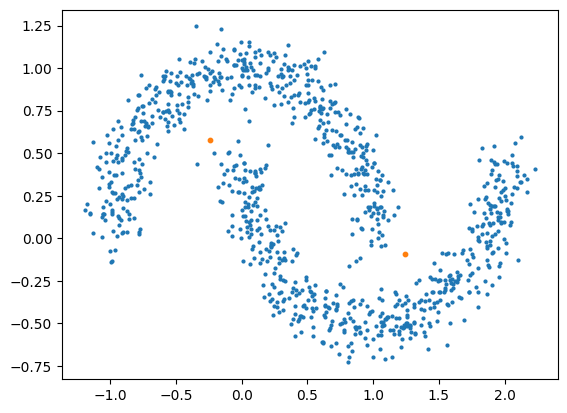

In [30]:
n = 1000
X, Y = make_moons(n, noise=0.1)
W, D, U = c_means(c = 2, X=X, m = 2)
plt.scatter(X[...,0], X[..., 1], s=4)
plt.scatter(W[:, 0], W[:, 1], s =10)
plt.show()

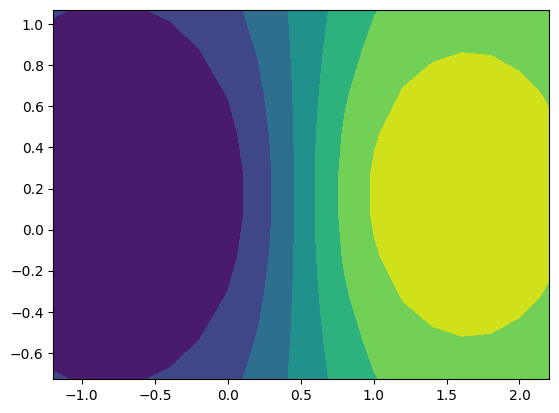

In [31]:
plot_contour(X, c_means, 2)

## Possibilistes

In [32]:
def update_U_poss(D, U, m, eta_r):
    for i in range(len(U)):
        for r in range(len(U[0])):
            somme = 0.
            for s in range(len(U[0])):
                somme += (D[i, r]/eta_r)**(2/(m-1))
            U[i, r] = 1/somme
    return U

In [33]:
def c_means_possibilistes(c, X, eta_r, m=2):
    n = len(X)
    d = len(X[0])
    # distance
    D = np.zeros(shape=(n, c))
    # degre d'appartenance
    U = np.zeros(shape=(n, c))

    W = init_W(X, c, d)
    converged = False
    while not converged:
        D = update_D(D, X, W)
        U = update_U_poss(D, U, m, eta_r)
        W_new = update_W(W, U, X, m)
        
        if is_converged(W_old=W, W_new=W_new, thresh=1e-1):
            converged = True
        W = W_new
    return W, D, U

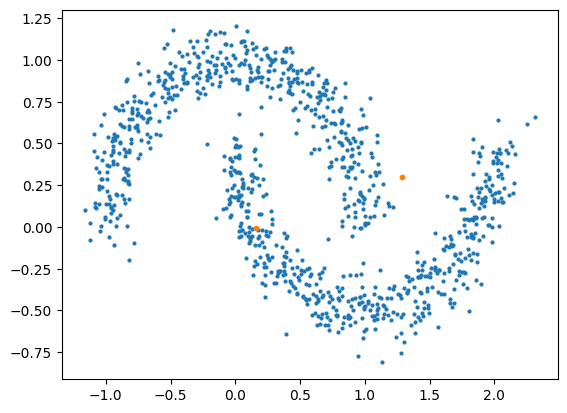

In [34]:
n = 1000
c = 2
X, Y = make_moons(n, noise=0.1)
W, D, U = c_means_possibilistes(c = 2, X=X, eta_r=0.01, m = 2)
plt.scatter(X[...,0], X[..., 1], s=4)
plt.scatter(W[:, 0], W[:, 1], s=10)
plt.show()

## Comparaisons avec d'autres algorithmes de clustering

### Gaussian Mixture Models

In [35]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, covariance_type='full', tol=0.001, max_iter=100, n_init=1, init_params='kmeans', random_state=None, verbose=0)
gmm.fit(X)

GaussianMixture(n_components=2)

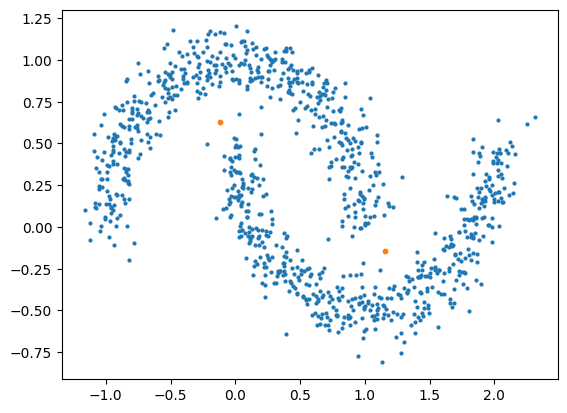

In [36]:
plt.scatter(X[...,0], X[..., 1], s=4)
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=10)
plt.show()

### Clustering Hierarchique

In [37]:
from sklearn.cluster import AgglomerativeClustering
agg_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=0.5)
model_agg_clust = agg_clust.fit(X)

In [38]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

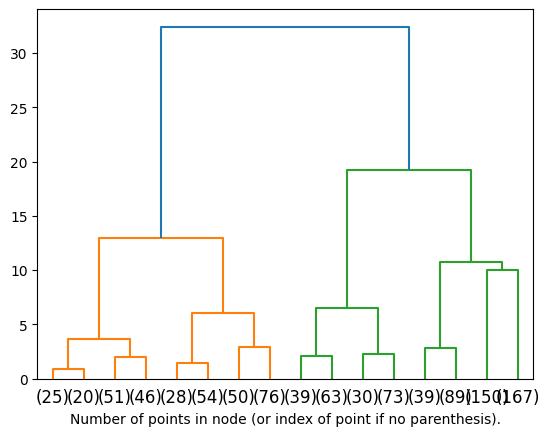

In [39]:
plot_dendrogram(model_agg_clust, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Clustering Spectral

In [40]:
from sklearn.cluster import SpectralClustering
spec_clust = SpectralClustering(n_clusters=2, random_state=None, n_init=10, gamma=1.0, affinity='rbf', degree=3, coef0=1)
spec_clust.fit(X)

SpectralClustering(n_clusters=2)

### DBScan

In [41]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)

DBSCAN()

## Conclusions

Les algorithmes de clustering sont utiles pour une méthode de classification qui a la limitation de générer une fonction d'appartenance binaire, ce qui n'est pas le cas dans la plupart des tâches de classification dans des applications réelles.

Les clusters non gaussiens permettent de voir l'efficacité et la robustesse des algorithmes. Dans le cas des Half Moons, l'algorithme dépend fortement d'une fonction de distances $d_{ir} = ||x_i - w_r||^{2}$ qui se voit affectée par la distribution des données, Ce qui cause que les distances causent que les longues distances aux poids causent une forte pénalisation à l'appartennance à un certain centre du cluster.